# Пример исследования особых точек поверхности, заданной параметрически

Рассмотрим некоторую поверхность, которая появляется в различных задачах, связанных с анализом устойчивости.
Ее параметрическое представление имеет вид:
$$
x = u\sin v,\quad y = (u + 1)\cos v,\quad z = 4u + 2\cos^2v + 1.
$$

Исследуем особенности этой поверхности.

In [1]:
import sympy as sym
from sympy import symbols, Function, Eq, solve, I, collect, expand, simplify, cancel, numer,\
                  Derivative, init_printing, series, evaluate, Poly, Matrix, sin, cos, groebner

init_printing()

In [2]:
x,y,z,t,u,v = symbols("x y z t u v",real = True)
Surf_param = [Eq(x,u*sin(v)), Eq(y, (u + 1)*cos(v)), Eq(z, 4*u + 2*cos(v)**2 + 1)]
Surf_param

Перейдем к полиномиальной параметризации, используя рациональную параметризацию окружности
$$
\cos(v)=\frac{1-t^2}{1+t^2},\quad \sin(v)=\frac{2t}{1+t^2}.
$$

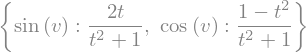

In [4]:
Subs_trig={cos(v):(1-t**2)/(1+t**2),sin(v):2*t/(1+t**2)}
Subs_trig

In [5]:
# Составим идеал для исключения переменных u,v
# Сделаем подстановку в правые части уравнений, затем составим разности
rhs_subs = [eq.rhs.subs(Subs_trig) for eq in Surf_param]
elim_Ideal = [numer(cancel(var-rhs)) for var,rhs in zip([x,y,z],rhs_subs)]
elim_Ideal

In [7]:
GB_elim_Ideal = groebner(elim_Ideal,u,t,x,y,z,order="grlex")

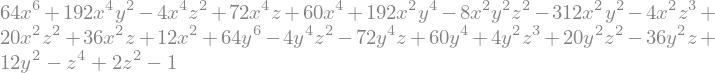

In [8]:
Surf_implicit = GB_elim_Ideal[0]
Surf_implicit

In [9]:
SP_sys = [Surf_implicit]+[Surf_implicit.diff(v) for v in (x,y,z)]

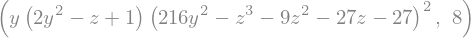

In [13]:
GB_SP_sys = groebner(SP_sys,x,y,z)
GB_SP_sys[-1].factor(),len(GB_SP_sys)

In [11]:
_,flst = sym.factor_list(GB_SP_sys[-1].factor())
flst

Выполним декомпозицию идеала с помощью найденных множителей

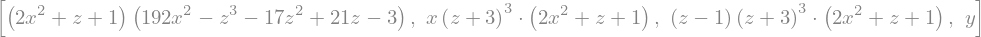

In [12]:
GB_SP_sysA = groebner(SP_sys+[flst[0][0]],x,y,z)
list(map(sym.factor,GB_SP_sysA))

Из структуры идеала видно, что решение - это парабола $z=-2x^2-1$, лежащая в плоскости $y=0$

In [14]:
# Найдем корни идеала как однопараметрическое семейство
sym.solve_poly_system(GB_SP_sysA,[y,z])

In [15]:
Subs_SP1 = dict([(v,eq) for v,eq in zip((y,z),sym.solve_poly_system(GB_SP_sysA,[y,z])[0])])
Subs_SP1

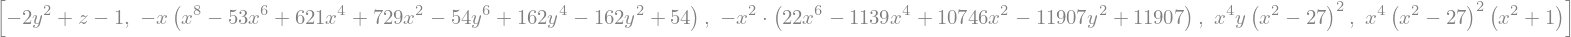

In [16]:
GB_SP_sysB = groebner(SP_sys+[flst[1][0]],z,y,x)
list(map(sym.factor,GB_SP_sysB))

Из структуры идеала видно, что решение - это парабола $z=2y^2+1$, лежащая в плоскости $x=0$

In [17]:
Subs_SP2 = dict([(v,eq) for v,eq in zip((x,z),sym.solve_poly_system(GB_SP_sysB,[x,z])[0])])
Subs_SP2

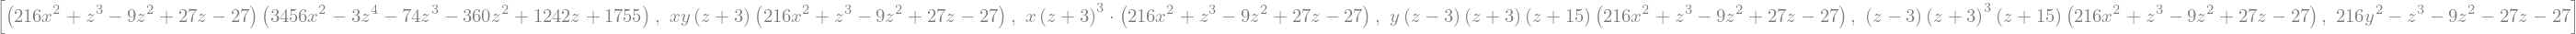

In [18]:
GB_SP_sysC = groebner(SP_sys+[flst[2][0]],x,y,z)
list(map(sym.factor,GB_SP_sysC))

Из структуры идеала легко видеть, что третья компонента множества особых точек является пересечение двух цилиндрических поверхностей 

In [19]:
Sys_SP3 = [GB_SP_sysC[-2].factor().args[-1],GB_SP_sysC[-1]]
Sys_SP3

In [20]:
phi = symbols(r"\varphi",real=True)
Sol_SP3 = {x:sin(phi)**3,y:cos(phi)**3,z:3*cos(2*phi)}
Sol_SP3

In [21]:
# Проверим параметризацию
[eq.subs(Sol_SP3).trigsimp() for eq in Sys_SP3]

Теперь визуализируем полученные многообразия.

Здесь используется пакет **sympy_plot_backends**:https://sympy-plot-backends.readthedocs.io/en/latest/install.html
Подробности установки соответствующих графических backends описаны в документации к пакету

In [22]:
from sympy.plotting import plot3d_parametric_surface, plot3d_parametric_line

from spb import *

In [23]:
Subs_SP1.update({x:x})
Subs_SP2.update({y:y})
Subs_SP1,Subs_SP2

In [24]:
Curve1 = [Subs_SP1[v] for v in [x,y,z]]
Curve2 = [Subs_SP2[v] for v in [x,y,z]]
Curve3 = [Sol_SP3[v] for v in [x,y,z]]
Surf = [eq.rhs for eq in Surf_param]

In [25]:
Curve1

In [26]:
P_Curve1 = plot3d_parametric_line(*Curve1,(x,-2,2),backend=PB,use_cm=False,line_color="red",label="Curve1",xlabel="x",ylabel="y",zlabel="z")

In [27]:
P_Curve2 = plot3d_parametric_line(*Curve2,(y,-2,2),backend=PB,use_cm=False,line_color="green",label="Curve2",xlabel="x",ylabel="y",zlabel="z")

In [28]:
from numpy import pi
P_Curve3 = plot3d_parametric_line(*Curve3,(phi,0,2*pi),backend=PB,use_cm=False,line_color="black",label="Curve3",xlabel="x",ylabel="y",zlabel="z")

In [29]:
P_Surf = plot3d_parametric_surface(*Surf,(u,-2,1),(v,0,2*pi),backend=PB,label="Surface",xlabel="x",ylabel="y",zlabel="z",wireframe=True)

In [30]:
(P_Surf+P_Curve1+P_Curve2+P_Curve3).show()

Теперь проверим, что вычисленные многообразия есть многообразия особых точек.
Для этого вычислим разложение неявного уравнения многообразия в ряд Тейлора вблизи кадлого такого множества.
Воспользуемся для этого вспомогательной процедурой _Taylor_polynomial_sympy_

In [31]:
def Taylor_polynomial_sympy(function_expression, variable_list, evaluation_point, degree):
    """
    Mathematical formulation reference:
    https://math.libretexts.org/Bookshelves/Calculus/Supplemental_Modules_(Calculus)/Multivariable_Calculus/3%3A_Topics_in_Partial_Derivatives/Taylor__Polynomials_of_Functions_of_Two_Variables
    :param function_expression: Sympy expression of the function
    :param variable_list: list. All variables to be approximated (to be "Taylorized")
    :param evaluation_point: list. Coordinates, where the function will be expressed
    :param degree: int. Total degree of the Taylor polynomial
    :return: Returns a Sympy expression of the Taylor series up to a given degree, of a given multivariate expression, approximated as a multivariate polynomial evaluated at the evaluation_point
    """
    from sympy import factorial, Matrix, prod
    import itertools
    n_var = len(variable_list)
    point_coordinates = [(i, j) for i, j in (zip(variable_list, evaluation_point))]  # list of tuples with variables and their evaluation_point coordinates, to later perform substitution
    deriv_orders = list(itertools.product(range(degree + 1), repeat=n_var))  # list with exponentials of the partial derivatives
    deriv_orders = [deriv_orders[i] for i in range(len(deriv_orders)) if sum(deriv_orders[i]) <= degree]  # Discarding some higher-order terms
    n_terms = len(deriv_orders)
    deriv_orders_as_input = [list(sum(list(zip(variable_list, deriv_orders[i])), ())) for i in range(n_terms)]  # Individual degree of each partial derivative, of each term
    polynomial = 0
    for i in range(n_terms):
        partial_derivatives_at_point = function_expression.diff(*deriv_orders_as_input[i]).subs(point_coordinates)  # e.g. df/(dx*dy**2)
        denominator = prod([factorial(j) for j in deriv_orders[i]])  # e.g. (1! * 2!)
        distances_powered = prod([(Matrix(variable_list) - Matrix(evaluation_point))[j] ** deriv_orders[i][j] for j in range(n_var)])  # e.g. (x-x0)*(y-y0)**2
        polynomial += partial_derivatives_at_point / denominator * distances_powered
    return polynomial

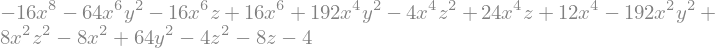

In [34]:
Taylor_polynomial_sympy(Surf_implicit,[x,y,z],Curve1,degree=2).simplify()

In [35]:
Taylor_polynomial_sympy(Surf_implicit,[x,y,z],Curve2,degree=1).simplify()

In [36]:
Taylor_polynomial_sympy(Surf_implicit,[x,y,z],Curve3,degree=1).trigsimp()#.simplify()